# A SHAP demo

## 1. About SHAP
*As stated in their readme*, SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

It's a unified project that combines work done from multiple <a href="https://github.com/slundberg/shap#citations">papers</a> over many years. With it, it's possible to estimate the reasons any machine learning model makes a decision by writing just a few lines of code. The reasoning is based on observations of the model performing on various data points. It first finds how the model behaves on background data (usually just features set to 0), and then it observes how the model is impacted when certain features in certain examples are swapped with the background data. For more details on how that exactly works, follow the cited <a href="https://github.com/slundberg/shap#citations">papers</a>.

In this notebook, we're going to go through an overview of how to use SHAP in multiple motivating examples.

## 2. Explaining diabetes degration

Here, we explain the output of a RandomForest model trained on a subset of the diabetes data available at https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html. It quantitatively measures diabetes degration over 1 year for 450 patients, noting down various characteristics to analyze what causes diabetes to degrade faster in some patients compared to others.

The data has 10 features: 
- Age
- Sex
- BMI (Body Mass Index)
- BP (Blood Preassure)
- 6 quantitative analysis of blood samples taken through the year labeled S1..S6

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
import shap

# load JS visualization code to notebook
shap.initjs()

data = datasets.load_diabetes()
X, y = data.data, data.target
model = RandomForestRegressor().fit(X[:-200],y[:-200])

# Initialize and train the explainer to explain all of our data
# (same syntax works for LightGBM, CatBoost, spark and xgboost models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)


#This is the most generalized visualizer and presents the most amount of information
shap.force_plot(explainer.expected_value, shap_values, X, feature_names=data.feature_names)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


The plot gives us a lot information to about the model, and can be interacted with to get even more information. The color red signifies that feature is pushing the predicted value higher, and the color blue signifies that the feature is pushing the predicted value lower. By default, the graph's x-axis shows samples ordered by similairy, and the y-axis shows the predicted output of the model. Sliding your mouse across the graph shows the significant features for each sample, and it can clicked to get the index of the sample in the original X's provided to it.

Moreover, you  can change the x-axis and the y-axis to show the details of SHAP analysis. Both axises are ordered by most to least significant features, all of which can be selected to view different information.

While keeping the y-axis on the output value, we can change the x-axis to see how changes in the selected feature impacts the output value. We can also change the y-axis to see how co-related the feature selected on the y-axis is to the feature select on the x-axis.


In this force plot, we can see that the blood sample taken before the last is the most significant feature driving our predictions, and BMI closely follows it. That is, a low value on the 5th sample most directly corresponds to a low degration score and a high value most directly corresponds to a high degration. 



Alongside the detailed force plot, we can also plot a number of other graphs to analyze the explanations given by SHAP (more details of which can be found at their <a href="https://github.com/slundberg/shap">Github page</a>). One of which is a dependency plot for our model. In this plot, we can directly map the dependency of the shap values over 2 features. 

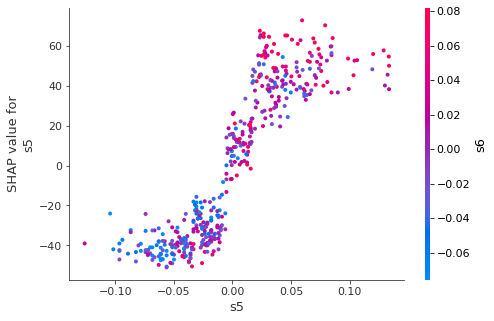

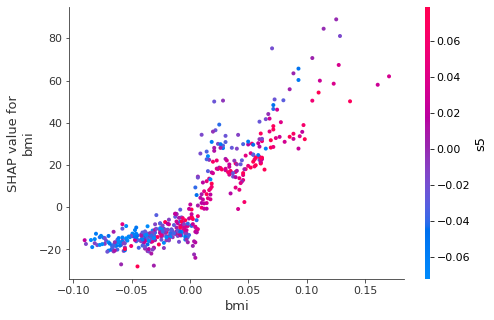

In [2]:
shap.dependence_plot("s5", shap_values, X, interaction_index="s6", feature_names = data.feature_names)
shap.dependence_plot("bmi", shap_values, X, interaction_index="s5", feature_names = data.feature_names)

From the dependence plots, we can confirm that blood samples taken from the same patient are in fact related to each other. Moreover, we can also observe the strong relationship from bmi and the blood samples.

## 3. Explaining movie rating predictions
Here, we try to find the most significant movie interactions impacting our model's predicted rating of the movie *Marriage Story* in our toy dataset based on ratings collected from students in our class.

SHAP, as we explained in the introduction, relies on observing the model's behavior when certain features are swapped with 0 or the provided background data. However, collaborative filtering does not produce a direct functional mapping from the users ratings to the predicted ratings. So, we can't directly use either collaborative filtering or SHAP's model-specific functions.

To get around those limitations, we can treat all the user ratings that SHAP tests as new users in our collaborative filtering method, and use SHAP's most generalized explainer, the Kernel Explainer to explain our predictions.

The data has 8 movies (and 24 users, with ratings given in [1..5] in whole numbers): 
- Parasite
- 1917
- Ford V. Ferari
- Joker
- The Hangover
- The Hangover 2
- The Hangover 3
- Marriage Story

##### NOTE:
In this problem, we treat our collaborative filtering method as a black box and use the kernel explainer to directly explain the rating of a particular movie based on our user-item matrix. This is fine because our matrix is neither extremely sparse nor has 10,000+ items. However, in practice, user-item matrices are extremely sparse and wide. In those cases, instead of treating our whole collaborative filtering model as a black box, we need to explain the mapping from the user-item matrix to the user and item hidden matrices, and then explain the interactions between them.

In [3]:
import numpy as np
from MF_ALS import MF
import os, contextlib

mat = np.load('./mat.npy')
movie_names = np.load('./movie_name.npy')
rank_to_rating = {0:5, 1:4.5, 2:4, 3:3.5, 4:3, 5:2.5, 6:2, 7:1.5}

#Train MF on known data
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        model = MF(mat, hidden=5, lr=0.01, epoch=50, bias=True)
        P, Q, Predictions = model.fit()

#Convert arbitrary user-item matrix from SHAP to normal discreet matrix
def tokenize(array):
    rows, cols = array.shape
    for i in range(rows):
        for j in range(cols):
            val = array[i][j]
            if val != 0:
                if val < 1.5:
                    array[i][j] = 1
                elif 1.5 < val <2.5:
                    array[i][j] = 2
                elif 2.5 < val < 3.5:
                    array[i][j] = 3
                elif 3.5 < val < 4.5:
                    array[i][j] = 4
                else:
                    array[i][j] = 5
    return array.astype(int)

#Take predicted ratings and output how a score for the item
# based on ratings of all the items 
def get_rating(recs, item_id):
    ans = []
    n_users, n_items = recs.shape
    for i in range(n_users):
        rec = {j: recs[i][j] for j in range(n_items)}
        rec = sorted(rec.items(), key=lambda x: x[1], reverse=True)
        idx = [id for id,rating  in enumerate(rec) if rating[0] == item_id]
        ans.append(rank_to_rating[idx[0]])
    return np.asarray(ans)

#Use pre-trained items to predict the ratings for new users
#Taken from Recdemo written by James Caverlee
def MF_predict(train, item_id=7):
    #normalize to [0..5] if not already
    train = tokenize(train)
    mask = 1.0 * (train > 0)
    num_users, t = train.shape
    #Make sure item we're predicting for isn't passed in
    for user in range(num_users):
        train[user][item_id] = 0
    user_bias = np.sum((train - model.global_bias) * mask, axis=1) / np.sum(mask, axis=1)
    sample_row, sample_col = train.nonzero()
    n_samples = len(sample_row)
    p_pred = np.random.random((num_users, model.hidden))
    for _ in range(25):
        training_indices = np.arange(n_samples)
        np.random.shuffle(training_indices)
        for idx in training_indices:
            u = sample_row[idx]
            i = sample_col[idx]
            rating = train[u,i]
            e = rating - p_pred[u,:].dot(model.Q[i,:].T) - model.global_bias - model.item_bias[i] - user_bias[u]
            p_pred += model.lr*(e * model.Q[i,:])
    recs = p_pred.dot(model.Q.T) + model.global_bias + model.item_bias + user_bias.reshape((-1, 1))
    return get_rating(recs, item_id)

In [4]:
X = np.asarray([mat[i] for i in range(mat.shape[0]) if mat[i][7]==0])

# Initialize and train the explainer to explain all of our data
explainer = shap.KernelExplainer(MF_predict, X)
# For the kernel explainer, we need to train over each sample many many times to converge
shap_values = explainer.shap_values(X, nsamples=100)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
invalid value encountered in true_divide


In [5]:
shap.force_plot(explainer.expected_value, shap_values, X, feature_names = movie_names)

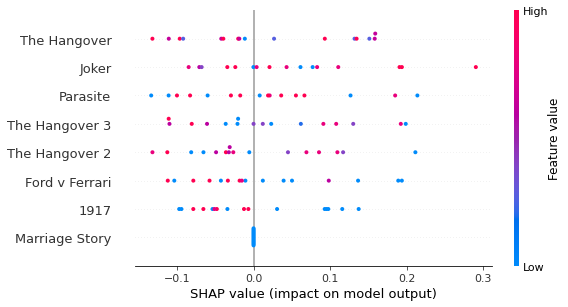

In [6]:
shap.summary_plot(shap_values, X, feature_names = movie_names)

From the force plot and the summary plot, we can see that ratings on "The Hangover" and "Joker" are the most important when it comes to predicting the rating a user might give to "Marriage Story". 

Not only so, we can further observe that a high rating on "The Hangover" drives down the score, while a high rating on "Joker" drives up the score. Since this is a small dataset, we can directly peak at the dataset and confirm that users who gave "The Hangover" a high rating disliked the Marriage Story, and that the users who gave a high rating to "Marriage Story" gave a low rating to "The Hangover". With "Joker", we can also observe the opposite effect from our data.

Critically, we also confirm that Marriage Story itself doesn't have any impact on the rating (because we always set its input ratings to 0 in training). A high value placed on its score would indicate that there are large inconsistencies in our explanations and that our explainer isn't trained well enough.

## References and other resources
- Other <a href="https://github.com/slundberg/shap#sample-notebooks">sample notebooks</a> on SHAP
- <a href="https://github.com/slundberg/shap/tree/master/docs/notebooks">Documentation and other resources</a> on SHAP
- Sci-kit learn <a href="https://scikit-learn.org/stable/datasets/index.html#datasets">Datasets</a>